In [ ]:
from google.colab import drive
drive.mount('/content/drive')


<ipython-input-2-36e9377654c4>:64: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-2-36e9377654c4>:73: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast("cuda"):
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1/20, Train Loss: 2.1894, Val Loss: 1.9525
Epoch 2/20, Train Loss: 1.8359, Val Loss: 1.5288
Epoch 3/20, Train Loss: 1.5291, Val Loss: 1.3673
Epoch 4/20, Train Loss: 1.2691, Val Loss: 1.2108
Epoch 5/20, Train Loss: 1.1033, Val Loss: 1.2330
Epoch 6/20, Train Loss: 0.9790, Val Loss: 0.9709
Epoch 7/20, Train Loss: 0.8986, Val Loss: 0.8136
Epoch 8/20, Train Loss: 0.8147, Val Loss: 1.0178
Epoch 9/20, Train Loss: 0.7586, Val Loss: 0.7450
Epoch 10/20, Train Loss: 0.7063, Val Loss: 0.6783
Epoch 11/20, Train Loss: 0.6622, Val Loss: 0.6325
Epoch 12/20, Train Loss: 0.6100, Val Loss: 0.6859
Epoch 13/20, Train Loss: 0.5568, Val Loss: 0.6401
Epoch 14/20, Train Loss: 0.5177, Val Loss: 0.5929
Epoch 15/20, Train Loss: 0.4606, Val Loss: 0.5165
Epoch 16/20, Train Loss: 0.4215, Val Loss: 0.4663
Epoch 17/20, Train Loss: 0.3830, Val Loss: 0.4248
Epoch 18/20, Train Loss: 0.3439, Val Loss: 0.4106
Epoch 19/20, Train Loss: 0.3223, Val Loss: 0.3914
Epoch 20/20, Train Loss: 0.3074, Val Loss: 0.3842
Accuracy:

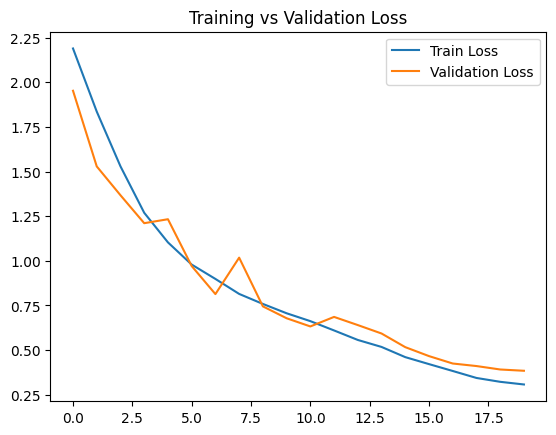

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

class FastVGG(nn.Module):
    def __init__(self, num_classes=10):
        super(FastVGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

def train_model(model, criterion, optimizer, scheduler=None, epochs=20):
    scaler = GradScaler()
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            with autocast("cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_losses.append(val_loss / len(test_loader))
        if scheduler:
            scheduler.step()
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
    return train_losses, val_losses

def evaluate_model(model):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    print(f"Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    return acc

model = FastVGG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

train_losses, val_losses = train_model(model=model,
                                       criterion=criterion,
                                       optimizer=optimizer,
                                       scheduler=scheduler,
                                       epochs=20)

evaluate_model(model)

torch.save(model.state_dict(), "fast_vgg_cifar10.pth")

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,label='Validation Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

def load_model(filepath):
    loaded_model = FastVGG().to(device)
    loaded_model.load_state_dict(torch.load(filepath))
    loaded_model.eval()
    return loaded_model

loaded_model = load_model("fast_vgg_cifar10.pth")
